# Basic Example: Train a MOFA model

This notebook shows a simple way to train a MOFA$^1$ model with additional sparsity priors. We use a chronic lymphocytic leukaemia (CLL) data set, which combined ex vivo drug response measurements with somatic mutation status, transcriptome profiling and DNA methylation assays$^2$.

1: Multi-Omics Factor Analysis-a framework for unsupervised integration of multi-omics data sets by Argelaguet, R. et al. (2018)  
2: Drug-perturbation-based stratification of blood cancer by Dietrich et al. (2018) 

In [1]:
import numpy as np
import anndata as ad2
import muon as mu
import scanpy as sc
import pyro
import seaborn as sns
import matplotlib.pyplot as plt
import cellij
from cellij.utils import load_model

import torch

/data/m015k/miniconda3/envs/cellij2/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/m015k/miniconda3/envs/cellij2/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/m015k/miniconda3/envs/cellij2/lib/python3.11/site-packages/uma

## Load CLL Data

In [2]:
mdata = cellij._data.Importer().load_CLL()

#### Preprocess data

In [3]:
# Normalize and log transform MRNA counts
sc.pp.normalize_total(mdata["mrna"], target_sum=1e4)
sc.pp.log1p(mdata["mrna"])

## Run Factor Analysis

In [4]:
# First we create an instance of a MOFA class
model = cellij.core.models.MOFA(n_factors=30, sparsity_prior="Horseshoe", device="cuda:0")

Using custom guide.


In [5]:
# Afterwards, we need to add the data to the model
model.add_data(data=mdata)

In [6]:
# We call `.fit` to train the model
# TODO: Add model saving and reloading
model.fit(
    likelihoods={
        "mrna": "Normal",
        "mutations": "Bernoulli",
        "drugs": "Normal",
        "methylation": "Normal",
    },
    epochs=20000,
    verbose_epochs=500,
    learning_rate=0.005,
    early_stopping=True,
    num_particles=10,
)

Training Model...
- Epoch      0/20000 | Train Loss:         735.61 	
- Epoch    500/20000 | Train Loss:         251.79 	| Decrease:  65.77%	| Time:  18.80s
- Epoch   1000/20000 | Train Loss:         208.89 	| Decrease:  17.04%	| Time:  18.84s
- Epoch   1500/20000 | Train Loss:         204.61 	| Decrease:   2.05%	| Time:  18.74s
- Epoch   2000/20000 | Train Loss:         202.49 	| Decrease:   1.03%	| Time:  18.76s
- Epoch   2500/20000 | Train Loss:         200.48 	| Decrease:   0.99%	| Time:  18.79s
- Epoch   3000/20000 | Train Loss:         199.75 	| Decrease:   0.36%	| Time:  18.82s
- Epoch   3500/20000 | Train Loss:         199.36 	| Decrease:   0.20%	| Time:  18.74s
- Epoch   4000/20000 | Train Loss:         199.12 	| Decrease:   0.12%	| Time:  18.85s
Early stopping of training due to convergence at step 4425
Training finished.
- Final loss: 198.86
- Training took 166.84s


## Plot Results

After training, we can inspect all the learned parameters, visualize the loss curve, etc.

#### Plot ELBO during training 

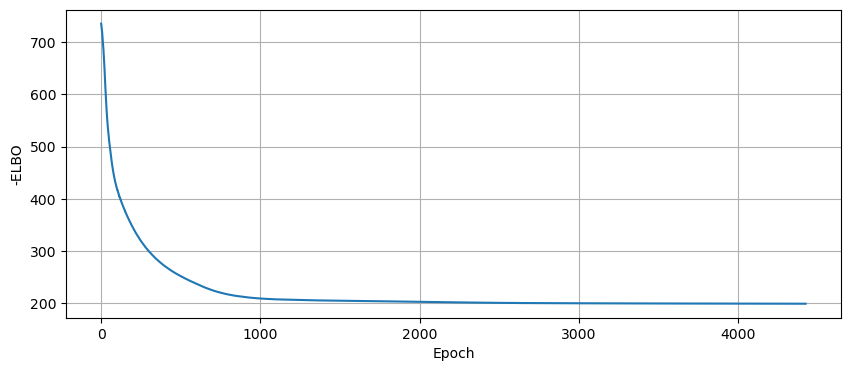

In [7]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.plot(model.train_loss_elbo)
plt.xlabel("Epoch")
plt.ylabel("-ELBO")
plt.grid(True)

#### Plot a heatmap of the weights and factors

The trained posteriors of weights and factors are accessible via `get_weights()` and `get_factors()` respectively.

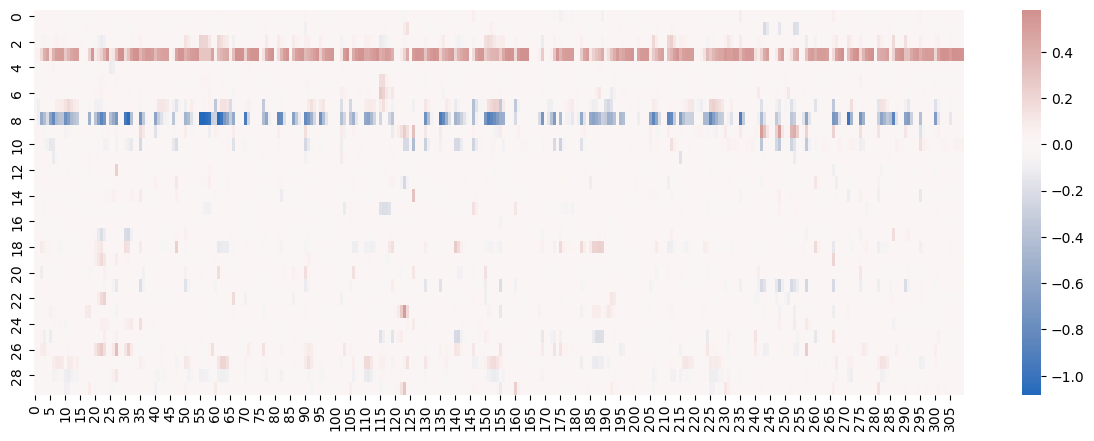

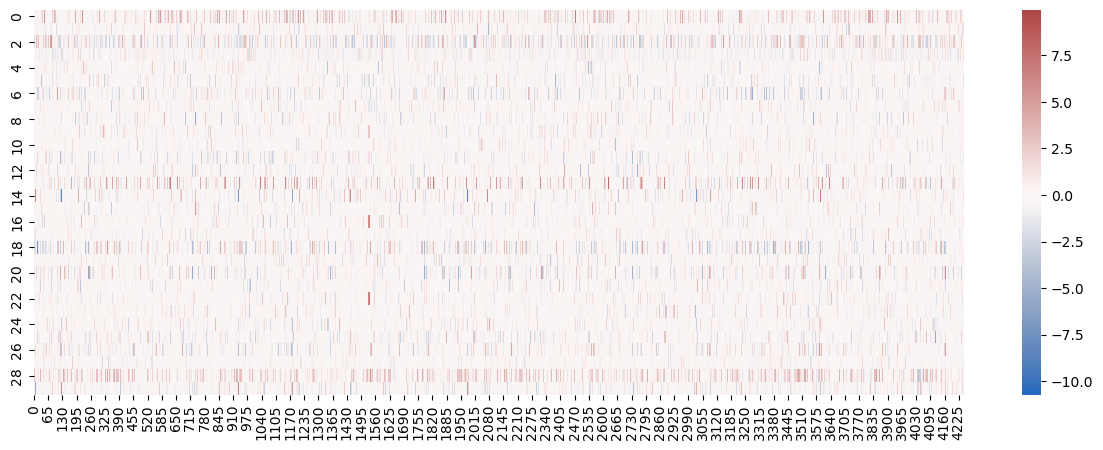

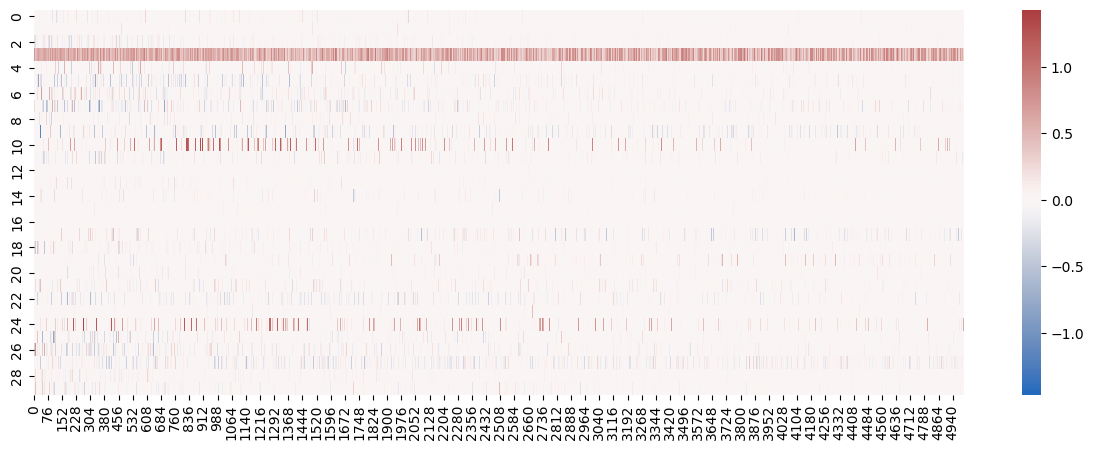

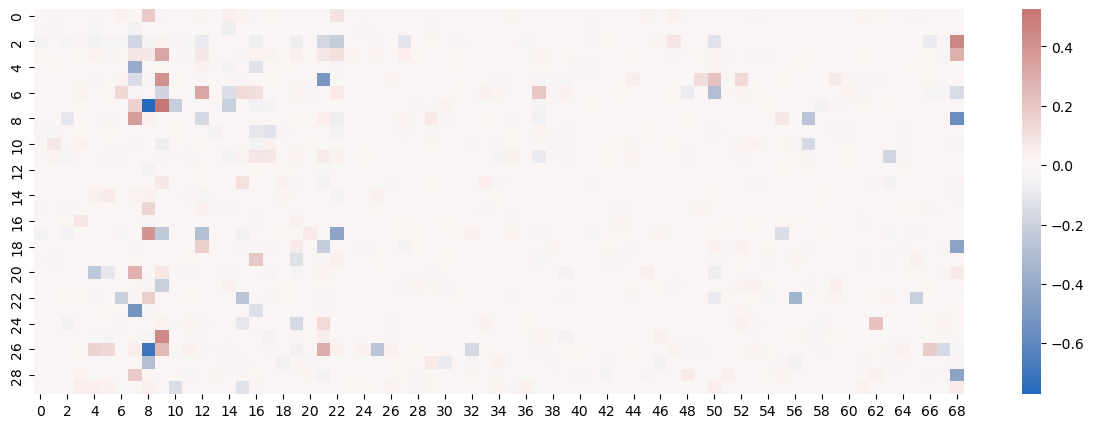

In [8]:
weights = model.get_weights(views="all")
for mod, w in weights.items():
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    sns.heatmap(w, cmap="vlag", center=0)
    plt.show()